Import needed libs:

In [59]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal

plt.rcParams['figure.figsize'] = [16, 8] # Matplotlib config

Load .mat data and covert to proper python arrays:

In [60]:
matData = scipy.io.loadmat('Painless021.mat')

print(type(matData))
print(matData)

bp = matData.get('bp')[0] # not sure why you get arrays of arrays
ecg = matData.get('ecg')[0] # note: this is 3x array
ppg = matData.get('ppg')[0]

f_bp = matData.get('f_bp')[0]
f_ecg = matData.get('f_ecg')[0]
f_ppg = matData.get('f_ppg')[0]

<class 'dict'>
{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Thu Nov  3 22:29:57 2022', '__version__': '1.0', '__globals__': [], 'bp': array([[72.81, 72.11, 71.56, ..., 70.3 , 71.16, 72.64]]), 'ecg': array([[-0.00082984, -0.00081711, -0.00081434, ..., -0.00232391,
        -0.00233045, -0.00232606],
       [-0.00209742, -0.00207858, -0.00207047, ...,  0.00073009,
         0.00072508,  0.00072484],
       [-0.00160103, -0.00159402, -0.00158911, ...,  0.00271969,
         0.0027215 ,  0.00271502]]), 'f_bp': array([[100]], dtype=uint8), 'f_ecg': array([[2000]], dtype=uint16), 'f_ppg': array([[1000]], dtype=uint16), 'ppg': array([[2087000, 2087268, 2087604, ..., 2396945, 2396970, 2396976],
       [1694830, 1695004, 1695136, ..., 1893987, 1893996, 1894017]])}


## Plot **initial** data:


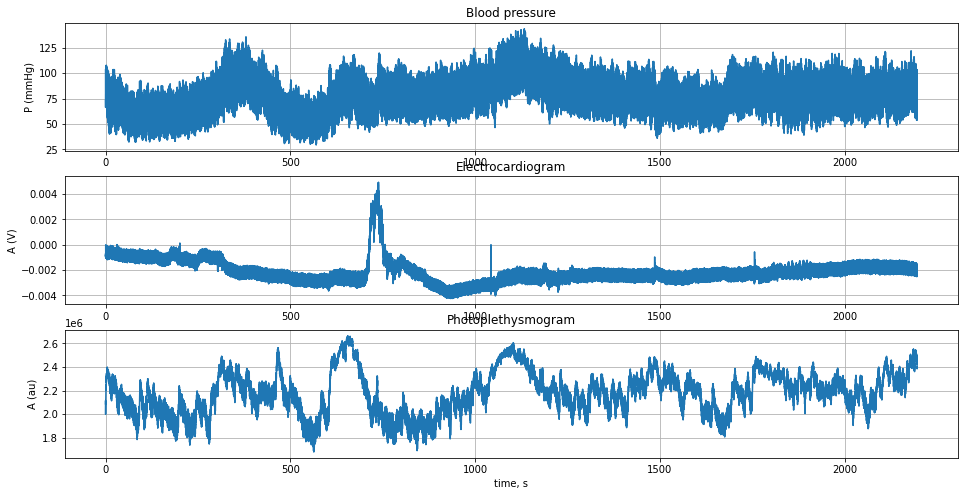

In [61]:
plt.figure()
plt.subplot(311)
time_bp = range(0, len(bp)) /f_bp
plt.plot(time_bp, bp)
plt.title('Blood pressure')
plt.ylabel('P (mmHg)')
plt.grid()

plt.subplot(312)
time_ecg = range(0, len(ecg)) /f_ecg
plt.plot(time_ecg, ecg)
plt.title('Electrocardiogram')
plt.ylabel('A (V)')
plt.grid()

plt.subplot(313)
time_ppg = range(0, len(ppg)) /f_ppg
plt.plot(time_ppg, ppg)
plt.title('Photoplethysmogram')
plt.ylabel('A (au)')
plt.xlabel('time, s')
plt.grid()
plt.show()

Find features from unfiltered data *(not sure if needed)*. Finding SBP and DBP from peaks:

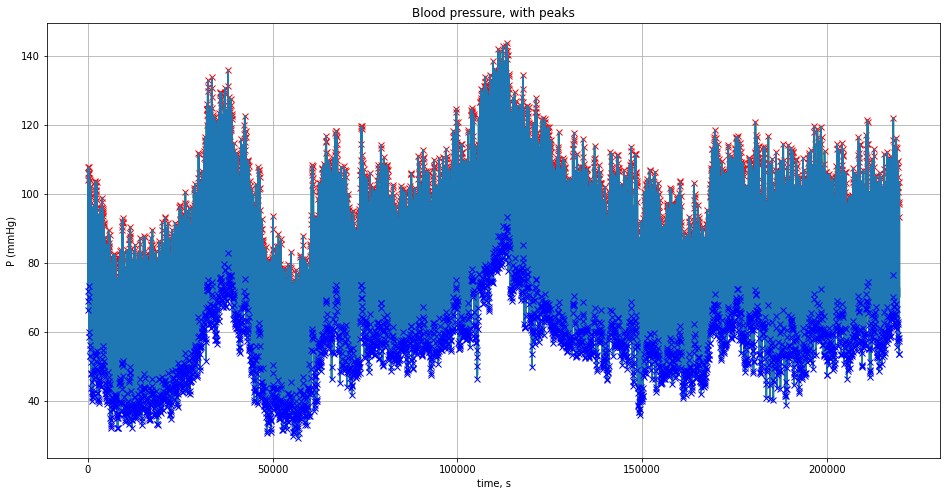

In [62]:
plt.figure()
locSBP, _ = find_peaks(bp, distance=50)
plt.plot(bp, "g")
plt.plot(locSBP, bp[locSBP], "rx")

locDBP, _ = find_peaks(-bp, distance=50)
plt.plot(bp)
plt.plot(locDBP, bp[locDBP], "bx")
plt.title('Blood pressure, with peaks')
plt.ylabel('P (mmHg)')
plt.xlabel('time, s')
plt.grid()
plt.show()

Find **MBP**:

In [63]:
# The problem is that SBP and DBP arrays aren't the same length
print(len(locSBP))
print(len(locDBP))

3233
3232


In [64]:
sigLen = np.minimum(len(locSBP), len(locDBP)) #TODO: we really are just dropping data?
tempSBP = bp[locSBP]
SBP = tempSBP[:sigLen]
tempDBP= bp[locDBP][:sigLen]
DBP= tempDBP[:sigLen]
MBP = (2*DBP + SBP) / 3

Plot all 3 features on the same graph:

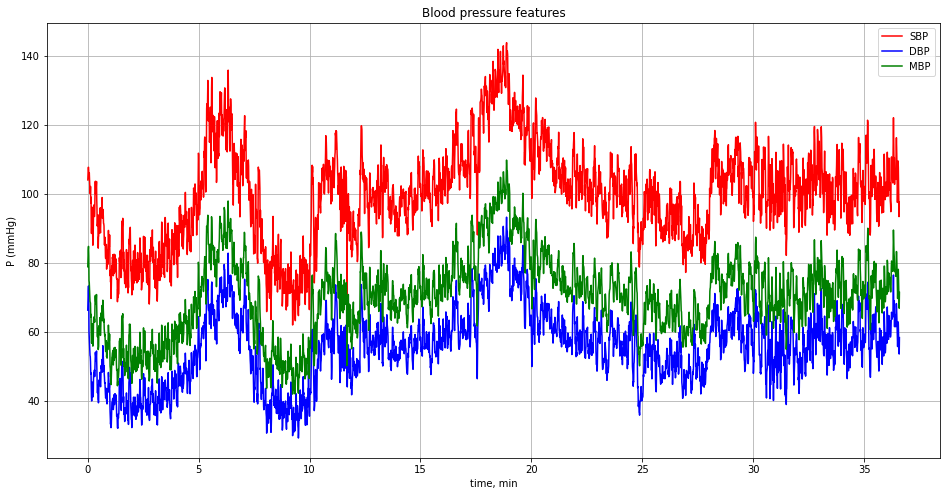

In [65]:
plt.figure()
t_SBP=locSBP[:sigLen] / f_bp;
plt.plot(t_SBP/60,SBP,'r', label='SBP')

t_DBP=locDBP[:sigLen] / f_bp;
plt.plot(t_DBP/60, DBP,'b', label='DBP')

t_MBP = range(0, sigLen) #TODO: check this
plt.plot(t_DBP/60, MBP,'g', label='MBP')
plt.legend()
plt.title('Blood pressure features')
plt.ylabel('P (mmHg)')
plt.xlabel('time, min')
plt.grid()
plt.show()

## Resample signals to same frequency

In [66]:
Fs = np.array([500])

bp_fs = signal.resample(bp, len(bp)*5) # 5 = 500 /100 TODO: fix


ecg_fs = signal.decimate(ecg, 4) #TODO: fix
timeEcg_fs = range(0, len(ecg_fs)) / Fs

ppg_fs = signal.decimate(ppg, 2) #TODO: fix
timePpg_fs = range(0, len(ppg_fs)) /Fs

## Create low-pass and high-pass filters

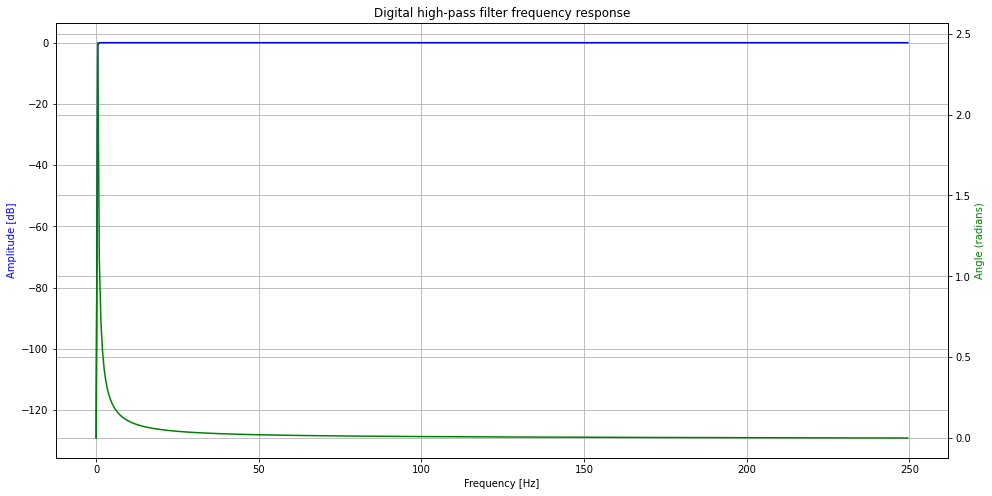

In [67]:
# Recommended filters values
f_co_hp = 0.5
f_co_lp = 17

b_highPass, a_highPass = signal.butter(4, (f_co_hp-0.1)/(Fs/2), btype = 'highpass')

w_1, h_1 = signal.freqz(b_highPass, a_highPass, fs=Fs)
fig, ax1 = plt.subplots()

ax1.set_title('Digital high-pass filter frequency response')
ax1.plot(w_1, 20 * np.log10(abs(h_1)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.grid(True)
ax2 = ax1.twinx()

angles = np.unwrap(np.angle(h_1))
ax2.plot(w_1, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid(True)
ax2.axis('tight')
plt.show()

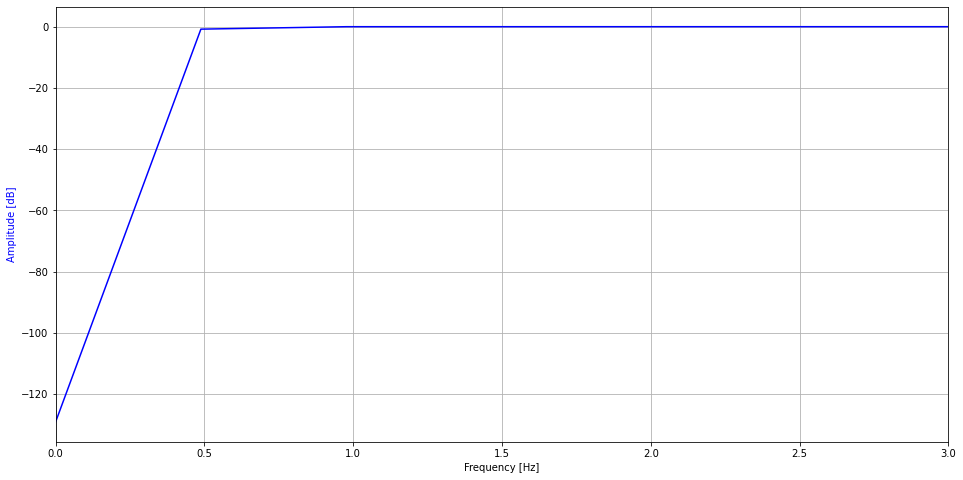

In [68]:
# Zoom in
plt.plot(w_1, 20 * np.log10(abs(h_1)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.xlim(0, 3.0)
plt.grid()
plt.show()

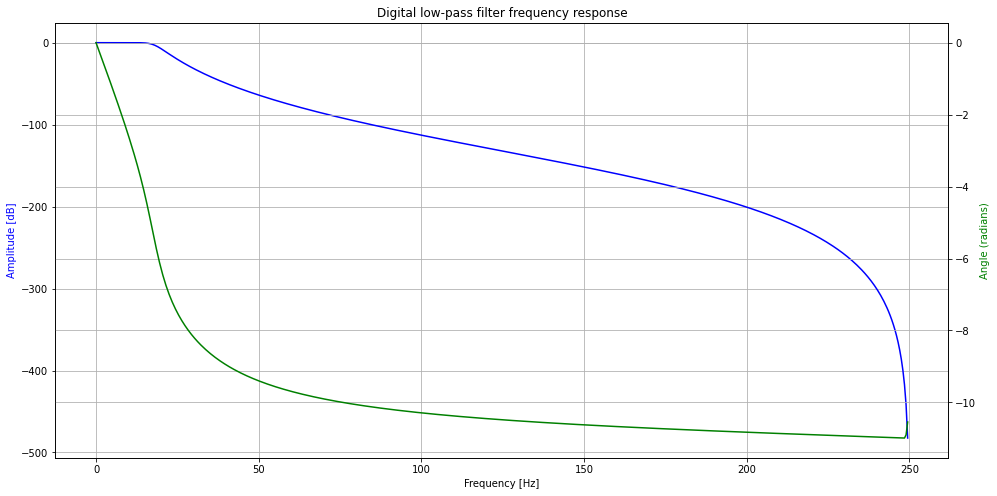

In [69]:
b_lowPass, a_lowPass = signal.butter(7, (f_co_lp+1)/(Fs/2), btype = 'lowpass')

w_2, h_2 = signal.freqz(b_lowPass, a_lowPass, fs=Fs)
fig, ax1 = plt.subplots()

ax1.set_title('Digital low-pass filter frequency response')
ax1.plot(w_2, 20 * np.log10(abs(h_2)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [Hz]')
ax1.grid(True)
ax2 = ax1.twinx()

angles = np.unwrap(np.angle(h_2))
ax2.plot(w_2, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')

ax2.axis('tight')
ax2.grid(True)
plt.show()

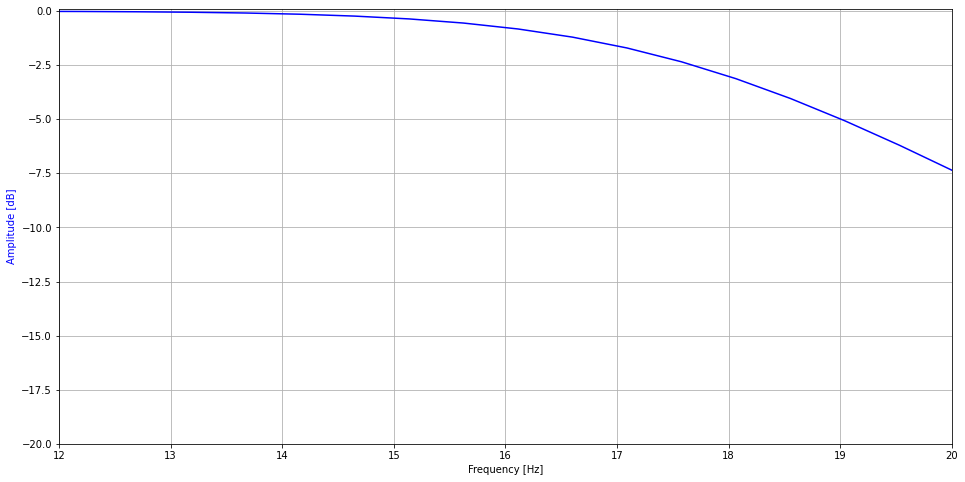

In [70]:
# Zoom in
plt.plot(w_2, 20 * np.log10(abs(h_2)), 'b')
plt.ylabel('Amplitude [dB]', color='b')
plt.xlabel('Frequency [Hz]')
plt.xlim(12, 20.0)
plt.ylim(-20, 0.1)
plt.grid()
plt.show()

## Apply filters

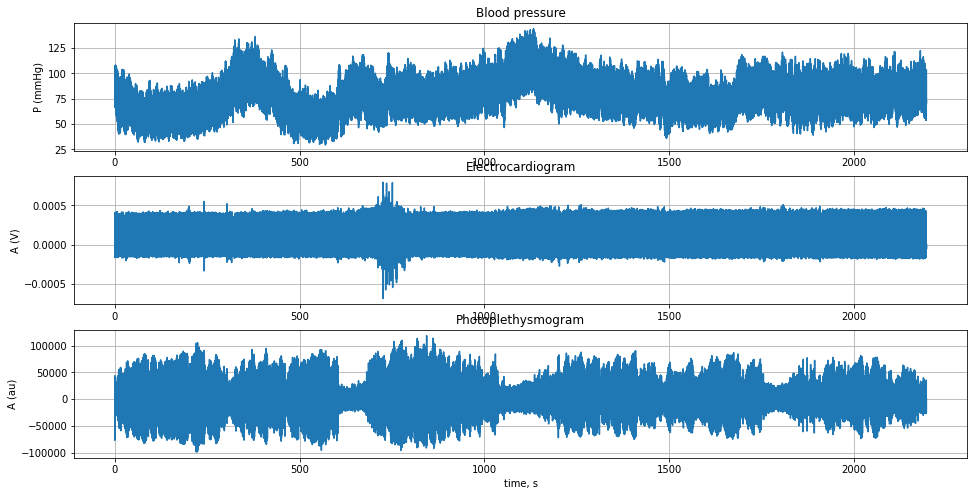

In [71]:
ecg_fs = signal.filtfilt(b_highPass, a_highPass, ecg_fs)
ppg_fs = signal.filtfilt(b_highPass, a_highPass, ppg_fs)

ecg_fs = signal.filtfilt(b_lowPass, a_lowPass, ecg_fs)
ppg_fs = signal.filtfilt(b_lowPass, a_lowPass, ppg_fs)

# Output
plt.figure()
plt.subplot(311)
time_bp_fs = range(0, len(bp_fs)) / Fs
plt.plot(time_bp_fs, bp_fs)
plt.title('Blood pressure')
plt.ylabel('P (mmHg)')
plt.grid()

plt.subplot(312)
time_ecg_fs = range(0, len(ecg_fs)) / Fs
plt.plot(time_ecg_fs, ecg_fs)
plt.title('Electrocardiogram')
plt.ylabel('A (V)')
plt.grid()

plt.subplot(313)
time_ppg_fs = range(0, len(ppg_fs)) / Fs
plt.plot(time_ppg_fs, ppg_fs)
plt.title('Photoplethysmogram')
plt.ylabel('A (au)')
plt.xlabel('time, s')
plt.grid()

plt.show()

## Extract the features from filtered and resampled signals

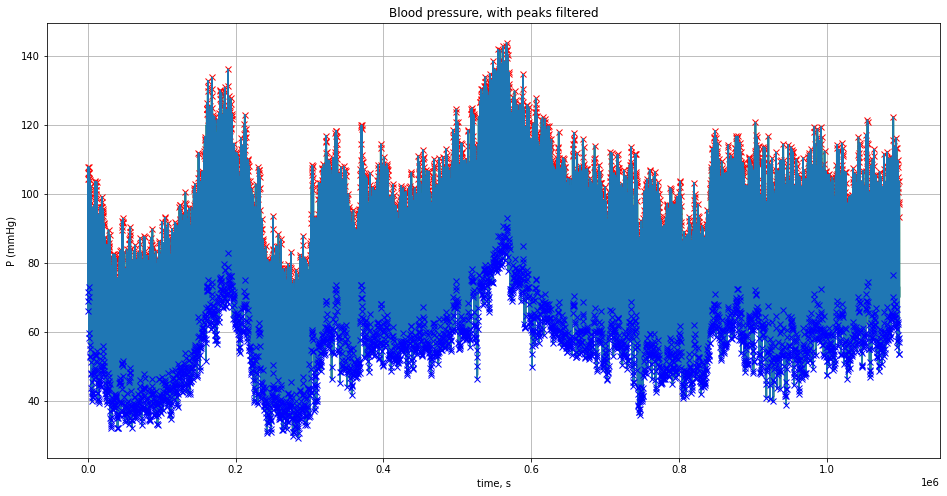

In [72]:
plt.figure()
locSBP_f, _ = find_peaks(bp_fs, distance=50*5)
plt.plot(bp_fs, "g")
plt.plot(locSBP_f, bp_fs[locSBP_f], "rx")

locDBP_f, _ = find_peaks(-bp_fs, distance=50*5)
plt.plot(bp_fs)
plt.plot(locDBP_f, bp_fs[locDBP_f], "bx")

plt.title('Blood pressure, with peaks filtered')
plt.ylabel('P (mmHg)')
plt.xlabel('time, s')
plt.grid()

plt.show()

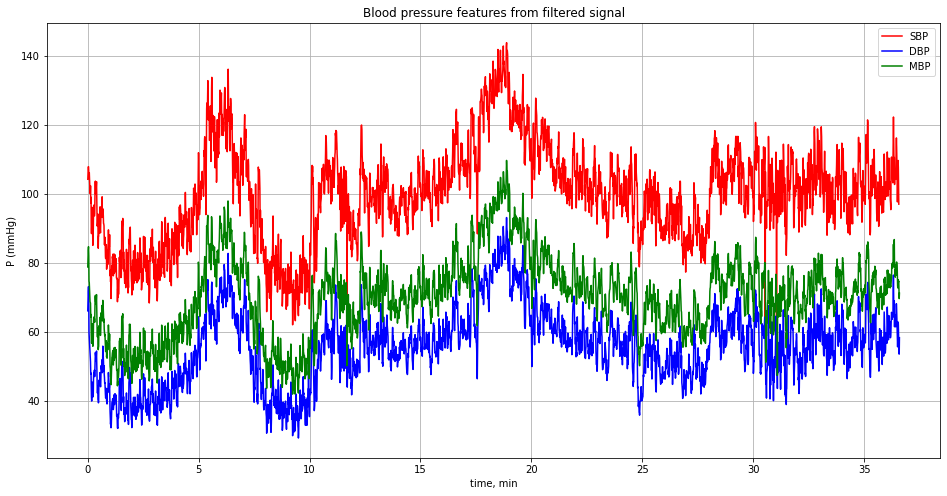

In [73]:

sigLen_fs = np.minimum(len(locSBP_f), len(locDBP_f)) #TODO: we really are just dropping data?

tempSBP_f = bp_fs[locSBP_f]
SBP_f = tempSBP_f[:sigLen_fs]
tempDBP_f= bp_fs[locDBP_f][:sigLen_fs]
DBP_f= tempDBP_f[:sigLen_fs]
MBP_f = (2*DBP_f + SBP_f) / 3


plt.figure()
t_SBP_f=locSBP_f[:sigLen_fs] / Fs;
plt.plot(t_SBP_f/60, SBP_f,'r', label='SBP')
# xlabel('beat No')

t_DBP_f=locDBP_f[:sigLen_fs] / Fs;
plt.plot(t_DBP_f/60, DBP_f,'b', label='DBP')

t_MBP_f = range(0, sigLen_fs) #TODO: check this
plt.plot(t_DBP_f/60, MBP_f,'g', label='MBP')
plt.legend()
plt.title('Blood pressure features from filtered signal')
plt.ylabel('P (mmHg)')
plt.xlabel('time, min')
plt.grid()

plt.show()